# 2016年美国共享单车骑行数据探究

## 目录
- [一、简介](#intro)
- [二、提出问题](#pose_questions)
- [三、数据收集和整理](#wrangling)
  - [浓缩骑行数据](#condensing)
- [四、探索性数据分析](#eda)
  - [统计数据](#statistics)
  - [可视化界面](#visualizations)


<a id='intro'></a>
## 一、简介


过去十年里，世界各城市的共享单车系统不仅不断增多，也越来越受人们欢迎。用户可借助共享单车系统来租赁单车，进行通常在 30 分钟以内的短途骑行。由于信息科技的崛起，用户能够方便地找到所用系统的停车点，实现单车解锁或归还操作。不仅如此，信息科技还带来了大量数据，有了这些数据，我们就能研究共享单车系统的使用情况。

在本项目中，我们将进行探索性数据分析。所需分析的数据源自 [Motivate](https://www.motivateco.com/)，这是一家为美国诸多大城市提供共享单车系统的供应商。我们将比较三大城市：纽约市、芝加哥和华盛顿特区的系统使用情况，并观察每个系统的长期注册用户和短期临时用户之间有无区别。

<a id='pose_questions'></a>
## 二、提出问题

1. 通过数据分析，我们需要知道什么季节的单车需求量最多，什么季节单车需求量最少，以此决定单车投放的数量；
2. 哪些站点的单车需求量较多，哪些站点的单车需求量较少，以此作为单车调度的依据

<a id='wrangling'></a>
## 三、数据收集与整理

在本项目中，我们将重点关注所选城市：纽约市、芝加哥、华盛顿特区 2016 年的个人骑行记录。每座城市均有相关页面供我们随时下载骑行数据：

- 纽约市(Citi Bike): [链接](https://www.citibikenyc.com/system-data)
- 芝加哥 (Divvy): [链接](https://www.divvybikes.com/system-data)
- 华盛顿特区 (Capital Bikeshare): [链接](https://www.capitalbikeshare.com/system-data)

In [58]:
## 导入所有必要的包和函数。
import csv # 读写 csv 文件
import pandas as pd
import numpy as np
from datetime import datetime # 日期解析操作
from pprint import pprint # 用于输出字典等数据结构
                          # 这比 base print 函数要好用。

In [59]:
def print_first_point(filename):
    """
    本函数会输出并返回指定的 csv 文件 （含页眉行）的第一个数据点（即文件的第二行）。
    """
    # 输出城市名以供参考
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        # 用 csv 库来设置一个 DictReader 对象。
        trip_reader = csv.DictReader(f_in)
        
        # 对 DictReader 对象使用函数，从而读取数据文件的第一条骑行记录并将其存储为一个变量 
        rows = []
        for row in trip_reader:
            rows.append(row)
        first_trip = rows[0]
        
        # 用 pprint 库来输出第一条骑行记录。
        pprint(first_trip)
        
    # 输出城市名和第一条骑行记录以备测试
    return (city, first_trip)

# 各城市的文件列表
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# 输出各文件的第一条骑行记录，并将其储存在字典中
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

我们可以看到输出了每座城市的名字（解析数据文件名而得），而其中第一条骑行记录也已解析成字典的格式。设置好`DictReader`对象，数据文件的第一行通常就会被处理为列名，文件其余的行则将以这些列名作为关键字，这是因为每一行都生成了一个字典对象。

<a id='condensing'></a>
### 浓缩骑行数据

我们从上方的输出观察到每座城市提供的信息是有差别的，就算是信息相同的部分，列名和格式有时也不尽相同。为了尽可能方便真正的探索操作，我们应当对数据进行修剪和清理。清理数据以保证各城市数据格式一致，修剪数据则能让我们把重心完全放到最关心的那部分数据上，从而减小探索难度。

修剪数据后将生成新的数据文件，该文件需包括五个骑行数据值：骑行时长、起始月份、起始小时、周几以及用户类型。每座城市的这五个值都可能需要额外的整理操作，这取决于各城市的数据差异：

- **时长**：该值可能以秒数（纽约市、芝加哥）或毫秒数（华盛顿特区）表示，但就分析而言，分析单位为分钟更佳，所以如果能将所有骑行时长都以分钟表示就好了。
- **月份**, **小时**, **周几**：季节、一天的什么时候以及是否周末都有可能影响骑客量，请用骑行起始时间来获取这些值。纽约市数据的时间戳记录了秒数，而华盛顿特区和芝加哥的并没有。 此处使用 [`datetime`](https://docs.python.org/3/library/datetime.html) 包应大有帮助，该包可实现必要的转换操作。
- **用户类型**： 共享单车系统的注册用户可能与临时用户有不同的使用模式。华盛顿特区将其用户分为两种：‘注册用户’ ——这类用户买了较长时期的会员，如年度会员或月度会员；‘临时用户’——这类用户所购买的骑行时间较短，如只有 24 小时或 3 天。纽约市和芝加哥的数据则用 ‘会员’ 和 ‘散客’ 来区分这两者。为了保证数据的一致性，需要修改华盛顿特区的标签，使其与另外两座城市的标签相同。

#### 数据处理
因为每条记录都需要重复处理，所以我们首先定义函数，然后调用函数处理数据

In [60]:
def duration_in_mins(datum, city):
    """
    将一个字典作为输入，该字典需包含一条骑行记录及记录城市的信息，返回该骑行的时长，该时长以分钟为单位。
    
    记住，华盛顿特区是以毫秒作为计量单位的，而芝加哥和纽约市则以秒数作为单位。
    
    提示：csv 模块会将所有数据读取为字符串，包括数值，所以转换单位时，需要用一个函数来将字符串转换为合适的数值类型。
    见 https://docs.python.org/3/library/functions.html
    """
    # 设置一个变量duration储存标准化后的骑行时间
    duration = 0
    if city in ['NYC','Chicago']:
        duration = float(datum['tripduration']) / 60
    elif city == 'Washington':
        duration = float(datum['Duration (ms)']) / 1000 / 60
    return duration


# 测试代码是否奏效，这里我们用断言子句判断代码是否出错，如果结果不相等，程序终止。
# 字典‘example_trips’是在输出每个数据源文件的第一条骑行数据时生成的。
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001 

In [62]:
def time_of_trip(datum, city):
    """
    将一个字典作为输入，该字典需包含一条骑行记录及记录城市的信息，返回该骑行进行的月份、小时及周几这三个值。
    
    记住，纽约市以秒为单位，华盛顿特区和芝加哥则不然。
    
    需要用 datetime 模块来将原始日期字符串解析为方便提取目的信息的格式
    """
    
    # 由于文件中的日期时间是字符串格式，所以我们需要将字符串格式转化为时间日期格式，储存在变量dt中；
    # datetime模块中的strptime函数就是将字符串转化为时间日期格式（注：参数的顺序、分隔符要与字符串的保持一致）
    # strftime() 用来格式化datetime对象,提取需要的日期信息
    if city == 'NYC':
        dt = datetime.strptime(datum['starttime'],'%m/%d/%Y %H:%M:%S')
        month = int(dt.strftime('%m'))
        hour = int(dt.strftime('%H'))
        day_of_week = dt.strftime('%A')
    elif city =='Chicago':
        dt = datetime.strptime(datum['starttime'],'%m/%d/%Y %H:%M')
        month = int(dt.strftime('%m'))
        hour = int(dt.strftime('%H'))
        day_of_week = dt.strftime('%A')
    elif city == 'Washington':
        dt = datetime.strptime(datum['Start date'],'%m/%d/%Y %H:%M')
        month = int(dt.strftime('%m'))
        hour = int(dt.strftime('%H'))
        day_of_week = dt.strftime('%A')
    return (month, hour, day_of_week)


# 测试代码是否奏效，这里我们用断言子句判断代码是否出错，如果结果不相等，程序终止。
# 字典‘example_trips’是在输出每个数据源文件的第一条骑行数据时生成的。
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [63]:
def type_of_user(datum, city):
    """
    将一个字典作为输入，该字典需包含一条骑行记录及记录城市的信息，返回进行该骑行的系统用户类型。
    
    华盛顿特区的类名与芝加哥和纽约市的不同。
    """
    
    # 对用户类型进行标准化
    if city in ['NYC','Chicago']:
        user_type = datum['usertype']
    elif city == 'Washington':
        user_type = 'Subscriber' if datum['Member Type']=='Registered' else 'Customer'
    return user_type


# 测试代码是否奏效，这里我们用断言子句判断代码是否出错，如果结果不相等，程序终止。
# 字典‘example_trips’是在输出每个数据源文件的第一条骑行数据时生成的。
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

对3个数据文件中的所有骑行记录调用函数，输出指定的数据文件，每个城市的骑行数据文件只包含：'duration'、'month'、'hour'、'day_of_week'、'user_type'等5个特征值

In [65]:
def condense_data(in_file, out_file, city):
    """
    本函数会从指定的输入文件中提取全部数据，并在指定的输出文件中写出浓缩数据；
    
    城市参数决定输入文件的解析方式。
    
    提示：参考下框以明确参数结构！
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # 设置 csv DictWriter 对象——该对象需将第一列列名作为 "fieldnames" 参数
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        # 设置 csv DictReader 对象
        trip_reader = csv.DictReader(f_in)

        # 收集并处理每行的数据
        for row in trip_reader:
            # 设置一个字典来存储清理和修剪后的数据点的值
            new_point = {}
            
            # 使用辅助函数来从原始数据字典中获取清理数据，并储存到字典中
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'] = time_of_trip(row, city)[0]
            new_point['hour'] = time_of_trip(row, city)[1]
            new_point['day_of_week'] = time_of_trip(row, city)[2]
            new_point['user_type'] = type_of_user(row, city)
            # 注意字典 new_point 的关键词应与上述 DictWriter 对象设置的列名一致。
            

            # 在输出文件中写出处理后的信息，此处用到写入函数writerrow()将字典中的值按照键和列名一一对应写入文件中
            # 见 https://docs.python.org/3/library/csv.html#writer-objects 
            trip_writer.writerow(new_point)
            

In [67]:
# 运行下框以测试效果
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    # 调用写入数据的函数
    condense_data(filenames['in_file'], filenames['out_file'], city)
    # 输出第一条数据
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])



<a id='eda'></a>
## 探索性数据分析

现在已经收集并整理了数据，可以开始探索数据了，对数据进行描述统计。

<a id='statistics'></a>
### 统计数据

首先，我们来进行一些基本统计。下方的第一个框里包括了一个函数，该函数会用 csv 模块来对给定的数据文件进行迭代处理，并返回会员和散客的骑行次数。第二个框则会运行 `/examples/` 文件夹里湾区示例数据中的函数。修改下框，回答下列问题。

**探究的问题**：哪座城市的骑行次数最多？哪座城市会员进行的骑行次数占比最高？哪座城市散客进行的骑行次数占比最高？

**答案**：纽约市的骑行次数最多，达到276798次；纽约市的会员进行的骑行次数占比最高（约0.888）；芝加哥的散客进行的骑行次数占比最高（约0.238）

In [39]:
def number_of_trips(filename):
    """
    本函数会读取一个骑行数据文件，分别报告会员、散客和所有系统用户的骑行次数。
    """
    with open(filename, 'r') as f_in:
        # 设置reader对象
        reader = csv.DictReader(f_in)
        
        # 初始化计数变量
        n_subscribers = 0
        n_customers = 0
        
        # 计算会员和散客的骑行次数
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        # 统计骑行总次数
        n_total = n_subscribers + n_customers
        # 计算会员骑行次数占比
        rate_subscribers = n_subscribers / n_total
        # 计算散客骑行次数占比
        rate_customers = n_customers / n_total
        # 返回结果（骑行总数，会员骑行占比，散客骑行占比）
        return(n_total,rate_subscribers,rate_customers)

In [68]:
# 创建一个字典，储存城市名及对应的标准化后的数据文件路径，以备函数调用
data_file = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC': './data/NYC-2016-Summary.csv'}
# 分别创建三个空字典储存骑行总次数，会员骑行占比，散客骑行占比
n_total_of_city = {}
rate_subscribers_of_city = {}
rate_customers_of_city = {}
# 将每个城市的骑行次数函数的返回值放入到对应的字典中
for city, filename in data_file.items():
    n_total_of_city[city] = number_of_trips(filename)[0]
    rate_subscribers_of_city[city] = number_of_trips(filename)[1]
    rate_customers_of_city[city] = number_of_trips(filename)[2]
# 输出骑行总次数，会员骑行占比，散客骑行占比的最大值及其对应的键
# items()的作用是将字典中的键和值作为元组输出，lambda是将每个元组的第二个值作为比较对象
print(max(n_total_of_city.items(), key=lambda x: x[1]))
print(max(rate_subscribers_of_city.items(), key=lambda x: x[1]))
print(max(rate_customers_of_city.items(), key=lambda x: x[1]))

('NYC', 276798)
('NYC', 0.8883590199351151)
('Chicago', 0.23774798630269925)


**探究的问题**：共享单车系统是为短途骑行者而设的，大多数时候用户在30分钟内骑行无需额外付费，若是超过该时长则需支付超时费用。那么，各城市的平均骑行时长是多少？各城市骑行时长超过30分钟的比例又是多少？

**答案**：Washington的平均骑行时长是18.93287355913721分钟，骑行时长超过30分钟的比例是0.10838886711093688;  
Chicago的平均骑行时长是16.563629368787335分钟，骑行时长超过30分钟的比例是0.08332062497400562;  
NYC的平均骑行时长是15.81259299802294分钟，骑行时长超过30分钟的比例是0.07302437156337835;

In [69]:
# 构建一个计算骑行时长的函数
def count_duration(filename,city):
    with open(filename,'r') as f_in:
        # 设置 csv DictWriter
        summary_reader = csv.DictReader(f_in)
        # 定义一个空列表来储存每次骑行时长
        duration_list = [] 
        for row in summary_reader:
            duration_list.append(float(row['duration']))
        # 总骑行时长   
        total_duration = 0
        # 骑行次数
        total_number = 0
        # 骑行时长超过30分钟的次数
        more_than_thirty_number = 0
        # 遍历骑行时长的列表
        for i in duration_list:
            total_duration += i
            total_number += 1
            if i > 30:
                more_than_thirty_number += 1
        # 求出平均骑行时长
        average_duration = total_duration / total_number
        # 求出骑行时长超过30分钟的占比
        more_than_thirty_rate = more_than_thirty_number / total_number
        return '{}的平均骑行时长是{}分钟，骑行时长超过30分钟的比例是{};'.format(city,average_duration,more_than_thirty_rate)

In [70]:
for city, filename in data_file.items():
    print(count_duration(filename,city))

Washington的平均骑行时长是18.93287355913721分钟，骑行时长超过30分钟的比例是0.10838886711093688;
Chicago的平均骑行时长是16.563629368787335分钟，骑行时长超过30分钟的比例是0.08332062497400562;
NYC的平均骑行时长是15.81259299802294分钟，骑行时长超过30分钟的比例是0.07302437156337835;


**探究问题**：研究华盛顿地区哪种系统用户的平均骑行时间更长？是会员还是散客？

**答案**：Washington的会员平均骑行时长为12.528120499294745分钟，散客平均骑行时长为41.67803139252976分钟，散客的平均骑行时长更长

In [71]:
# 构建一个求会员和散客平均骑行时长的函数
def average_duration(filename,city):
    with open(filename,'r') as f_in:
        # 设置 csv DictWriter
        summary_reader = csv.DictReader(f_in)
        # 定义会员骑行总时长、会员骑行次数、散客骑行总时长、散客骑行次数4个变量
        subscriber_duration = 0
        subscriber_number = 0
        customer_duration = 0
        customer_number = 0
        # 遍历数据表
        for row in summary_reader:
            if row['user_type'] == 'Subscriber':
                subscriber_duration += float(row['duration'])
                subscriber_number += 1
            else:
                customer_duration += float(row['duration'])
                customer_number += 1
        # 返回会员和散客的平均骑行时长
        return '{}的会员平均骑行时长为{}分钟，散客平均骑行时长为{}分钟'.format(city,subscriber_duration/subscriber_number,customer_duration/customer_number)
# 选择华盛顿的骑行数据
average_duration('./data/Washington-2016-Summary.csv','Washington')


'Washington的会员平均骑行时长为12.528120499294745分钟，散客平均骑行时长为41.67803139252976分钟'

<a id='visualizations'></a>
### 可视化界面

我们发现会员和散客的骑行时长不合常理：会员平均骑行时长远低于30分钟，而散客的平均骑行时长则超过了30分钟！要是能观察骑行时长的分布，应该会很有趣，为此，我们需要引入一个新库，即 `matplotlib`。

In [1]:
# 加载库
import matplotlib.pyplot as plt
import seaborn as sns
# 这个'咒语'能展示图形。
%matplotlib inline 
# 美化作图
plt.style.use('classic')

现在为华盛顿的骑行时长创建直方图

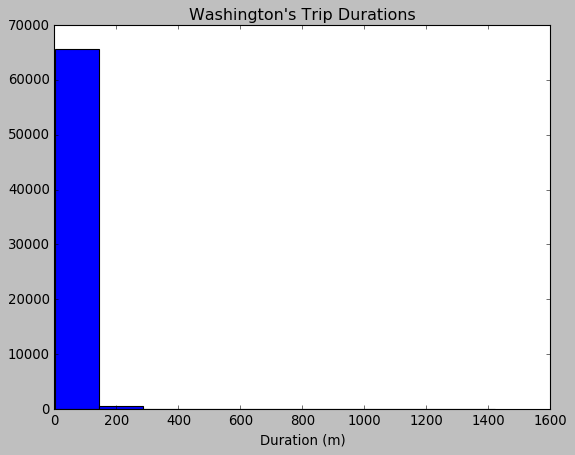

In [73]:
# 使用本框及新框来收集所有骑行时长并制成列表
# 使用 pyplot 函数来为骑行时长生成直方图
with open('./data/Washington-2016-Summary.csv','r') as f_in:
    summary_reader = csv.DictReader(f_in)
    # 创建空列表储存骑行时长的数据
    duration_list = []
    for row in summary_reader:
        duration_list.append(float(row['duration']))
    plt.hist(duration_list)
    plt.title("Washington's Trip Durations")
    plt.xlabel('Duration (m)')
    plt.show()


该图左侧将有一条极长的柱形，相邻的第二条柱形则可能十分短小，而且中间和右边将空出许多空间，这个时候我们发现 x 轴的时长值有些高度异常的极端值，不过不需要重新处理数据，只需为 `.hist()` 函数再加一些参数，限制绘图数据的范围即可，函数相关文件请见[[这里]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**探究问题**：为华盛顿的会员骑行时长绘制分布图，并单独为散客做同样的操作。限制统计图的范围，仅绘制骑行时长小于 75 分钟的数据。另外，设置每条柱形之间有五分钟的间隔。在每组数据中，各分布图的峰值分别在哪？如何描述每个分布图的形状？

**答案**：在Washington的骑行数据中，会员的骑行时长分布图的峰值在[5,10)的区间内，散客的骑行时长分布图的峰值在[15,20)的区间内，会员的骑行时长分布相对集中，而且异常值较少；散客的骑行时长分布相对于会员比较分散，而且异常值较多，所以造成散客的平均骑行时长大于30分钟；

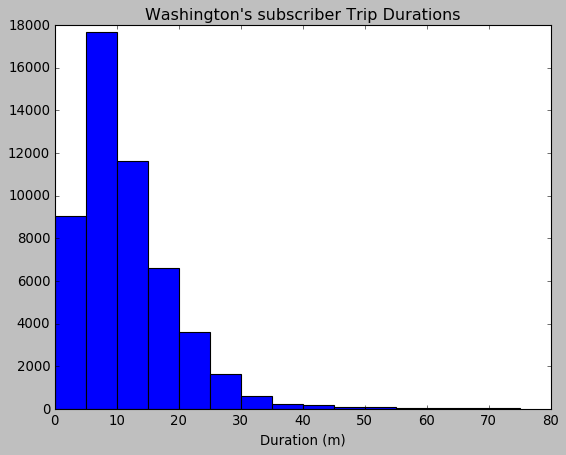

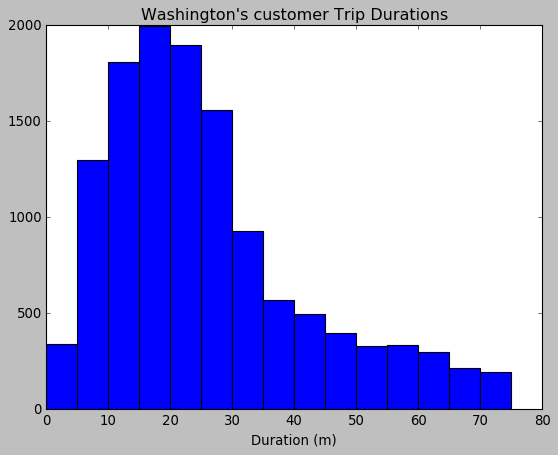

In [74]:
## 使用本框及新框来回答问题 5##
with open('./data/Washington-2016-Summary.csv','r') as f_in:
    summary_reader = csv.DictReader(f_in)
    # 设置空列表储存会员的骑行时长数据
    subscriber_duration_list = []
    # 设置空列表储存会员的骑行时长数据
    customer_duration_list = []
    for row in summary_reader:
        if row['user_type'] == 'Subscriber':
            subscriber_duration_list.append(float(row['duration']))
        else:
            customer_duration_list.append(float(row['duration']))
    #绘制会员骑行时长分布图
    plt.hist(subscriber_duration_list,bins=15,range=(0,75))
    plt.title("Washington's subscriber Trip Durations")
    plt.xlabel('Duration (m)')
    plt.show()
    #绘制散客骑行时长分布图
    plt.hist(customer_duration_list,bins=15,range=(0,75))
    plt.title("Washington's customer Trip Durations")
    plt.xlabel('Duration (m)')
    plt.show()

**探究问题**：纽约市的共享单车不同月份的骑行量有什么区别？哪个月份的骑行量最多？会员和散客的骑行量分别是哪个月份最多？

**答案**: 从下方的柱形图可以看出，纽约市的共享单车骑行次数最多的月份是九月，其中会员和散客骑行次数最多的月份也是在九月；并且我们可以看出6-10月的骑行次数都远高于其他月份，此时正是夏秋两季，所以我们可以考虑在6-10月份加大单车的投放量以满足市场需求，在12-2月份进行单车的回收保养

Text(0,0.5,'count')

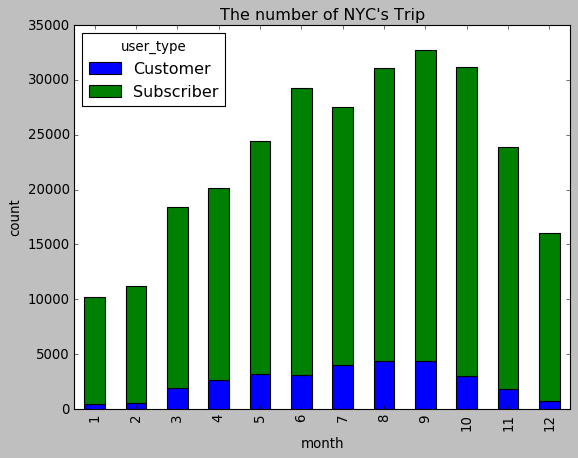

In [75]:
import pandas as pd
# 这里我们用到pandas库来进行数据的分组处理，
NYC_data = pd.read_csv('./data/NYC-2016-Summary.csv')
# 按照月份和用户类型进行分组；
# count():是计算元素个数的函数（不包含空值、NAN值）；
# unstack():将多层次索引的series转化为DataFrame；
# plot():参数kind是指定什么类型的图，这里使用柱形图'bar'；参数stacked是指定是否堆积显示；
NYC_data.groupby(['month','user_type'])['user_type'].count().unstack().plot(kind='bar',stacked=True)
plt.title("The number of NYC's Trip")
plt.ylabel("count")